# Implementing a First-Order Lag Filter

- Author: Siang Lim
- Date: Oct 16th 2022

## Background

The lag filter is the simplest discrete time, first-order filter, defined as:

$$ y(t) = \alpha x(t) + (1-\alpha) \cdot y(t-1)$$

Where:

- $x(t)$ is the input signal at time step $t$.
- $y(t)$ is the filtered output at time step $t$.
- $\alpha$ is the smoothing constant with a value between 0 and 1. $\alpha=1$ means no smoothing.

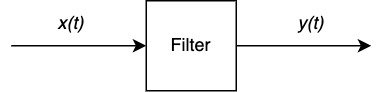

In other words, the lag filter is defined as a weighted sum of incoming measurement values, with weights determined by $\alpha$.

- A lower $\alpha$ gives less weight to the new input $x(t)$ and provides more smoothing.

##### References

- https://gregstanleyandassociates.com/whitepapers/FaultDiagnosis/Filtering/Exponential-Filter/exponential-filter.htm
- http://carsystemsltd.com/FCManual/fc_3_-_lead___lag.htm

In [1]:
# import libraries
%matplotlib inline
%config InlineBackend.figure_formats = {'svg',}

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.interpolate import interp1d
import pandas as pd

# animation libraries
from IPython.display import display
from matplotlib import animation
from IPython.display import HTML

sns.set_style('white')
sns.set_context("notebook")

## Simple Implementation

We start with a simple implementation of exponential filtering by assuming that we have the entire input array $x$ available upfront. This is not a realistic assumption for any practical, online applications.

In [2]:
def expfilt(x, alpha=0.5):
    """
    Perform first order exponential filtering online
    
    Parameters
    ----------
    x : array-like
        The input array, x(t)
    alpha : double
        The smoothing parameter
        
    Returns
    -------
    out : array-like
        The filtered output array, y(t)
        
    """
    
    y = np.zeros(len(x)) # initialize the y output array
    y[0] = x[0]          # initialize the first y output = first x measurement
    
    # calculate y(t) from y(t-1) and x(t)
    for i in range(1,len(y)):
        y[i] = alpha*x[i] + (1-alpha)*y[i-1]
    
    return y

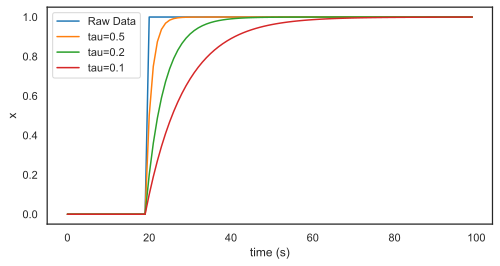

In [3]:
# create our step signal
plt.figure(figsize=(8,4))
max_time  = 100
step_time = 20
x = np.zeros(max_time)
x[step_time:] = 1

# show our signal using seaborn
ax = sns.lineplot(data=x)
ax.set(xlabel='time (s)', ylabel='x');

# plot output at different alphas
alphas = [0.5, 0.2, 0.1]
for alpha in alphas:
    sns.lineplot(data=expfilt(x, alpha))

# add the legends
legends = ['tau=' + str(alpha) for alpha in alphas]
ax.legend(['Raw Data'] + legends);

## Physical interpretation of $\alpha$

In most DCS systems, like the ABB Bailey system, a first-order filter is implemented as a `lead-lag` block. In the lead-lag block, users need to set the filter time constant, $T$, instead of the smoothing parameter $\alpha$ directly.

The filter time constant, $\tau$ is defined as the time required for the output signal to reach $63.2\%$ of its final value. The relationship between $\alpha$ and $\tau$ is:

$$
\alpha = 1-e^{-1/\tau}
$$

- A higher $\tau$ gives less weight to the new input $x(t)$ and provides more smoothing.
- In this workbook, we assume constant sampling time, $dt = 1$ for simplicity.
- It takes approximately $5\tau$ for the output signal to reach 99% of its final value.


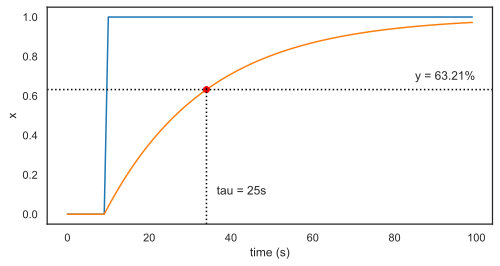

In [4]:
plt.figure(figsize=(8,4))

# create our step signal
step_time = 10
max_time  = 100
x = np.zeros(max_time)
x[step_time:] = 1

# show our signal using seaborn
ax = sns.lineplot(data=x)
ax.set(xlabel='time (s)', ylabel='x');

# plot output at different alphas
tau = 25
alpha = 1-np.exp(-1/tau)
sns.lineplot(data=expfilt(x, alpha))

# add the legends
legends = [str(alpha) for alpha in alphas]

# find x where y = 63.2%
y_search = 0.6321205588285579
t_index = np.argmin(np.abs(expfilt(x, alpha)-y_search))

plt.plot(t_index, y_search, "or")
plt.text(max_time-15, y_search + 0.05, f"y = {y_search*100:.2f}%") # add 1 because of Python zero-indexing
plt.text((t_index+2.5) , 0.1, f"tau = {t_index-step_time+1}s") # add 1 because of Python zero-indexing
plt.axvline(t_index, 0, expfilt(x, alpha)[t_index], color='black', linestyle='dotted')
plt.axhline(y_search, color='black', linestyle='dotted')

## DCS and Online Implementation

In an actual online application, we are working with streaming data and will not have the entire input array $x$ upfront. We must modify our implementation to handle each data point recursively, as shown below.

We will use Python generator functions and `yield` to do this effectively.

### References
- https://jckantor.github.io/CBE30338/04.01-Implementing_PID_Control_with_Python_Yield_Statement.html

In [5]:
def expfilt_online(alpha=0.5):
    """Perform first order lag filtering (one point at a time, online implementation using yield)"""
    
    # initialize yprev and x to 0 since we don't have any values yet
    yprev = 0
    x = 0
    
    # infinite loop, yield and wait for next measurement x(t)
    while True:
        y = alpha*x + (1-alpha)*yprev # calculate current y
        x = yield y                   # yield y and store new x
        yprev = y                     # store yprev for next iteration

### Explanation

Regular Python functions have a single exit point when `return` is called. The presence of a `yield` statement will turn the regular function into a generator function.

#### Why use generator functions?
A generator function allows us to preserve a memory of the internal function variables, which is exactly what we need for storing `yprev` or doing any kind of streaming control calculations (like a PID loop)! The generator function will go into a suspended state when it encounters the `yield` statement and return control to the main calling function. The next time the generator function is called, it will pick up where it left off and execute until the next yield statement again.

### Example - What is `yield` doing?
Let's look at an example on how to use our generator function.


In [6]:
# make a generator function called my_filter with alpha = 0.5
my_filter = expfilt_online(alpha=0.5)

We will use `send(None)` to initialize our generator function. This makes the function execute until the next `yield` statement. It will return `y` to us and then stop, and we just initialized `y` to 0.

In [7]:
# initialization. we must always send a None value to initialize a generator
my_filter.send(None) # we expect a return value of 0 since we initialized x = yprev = 0

0.0

Next, we will try sending `x = 0` to our function. When we call `send()`, the function will pick up execution from the last yield statement. Since we have the statement `x = yield y`, our function is expecting to receive an `x` value, which we are passing to it via `send(x)`.

The generator function will then run through its calculations in the while loop until it hits the `yield` statement again.

In [8]:
# first iteration
print(f"Iteration 1: {my_filter.send(0)}")

Iteration 1: 0.0


For the next few iterations, let's try repeatedly sending 1. We should see the filter start smoothing the output

In [9]:
for i in range(10):
    print(f"Iteration {i+2}: {my_filter.send(1):.10f}")

Iteration 2: 0.5000000000
Iteration 3: 0.7500000000
Iteration 4: 0.8750000000
Iteration 5: 0.9375000000
Iteration 6: 0.9687500000
Iteration 7: 0.9843750000
Iteration 8: 0.9921875000
Iteration 9: 0.9960937500
Iteration 10: 0.9980468750
Iteration 11: 0.9990234375


## Error handling in a robust, online implementation

We can't trust that our measurements will always be available or the values we receive would always be valid. Sensors and instruments may fail and send us garbage values.

At the very least, our filter should be able to handle NaNs correctly without throwing an error. 

### Discussion
One option for error handling to hold the previous x value if the measurement is not available or reading garbage values (i.e. zero-order hold).

Of course, the 'correctness' of this implementation highly depends on the application. In some situations, it may be unsafe to hold the last value, and we should allow the output to fail when it receives an invalid input, and  then clear the filter memory until we get good inputs.

For demonstration purposes, let's assume that it is acceptable to hold the last value for our application.

In [10]:
import numbers
def expfilt_online_robust(alpha=0.5):
    """Perform online first order lag filtering with error handling"""
    
    # initialize yprev and x to 0 since we don't have any values yet
    yprev = 0
    xprev = 0
    x = 0
    
    # infinite loop, yield and wait for next measurement x(t)
    while True:
        y = alpha*x + (1-alpha)*yprev # calculate current y
        x = yield y                   # yield y and store new x
        if not isinstance(x, numbers.Number) or np.isnan(x):
            x = xprev
        yprev = y                     # store yprev for next iteration 
        xprev = x                     # store xprev for error handling        

Let's test our implementation:

In [11]:
robust_filter = expfilt_online_robust(alpha=0.5)
robust_filter.send(None)

original_filter = expfilt_online(alpha=0.5)
original_filter.send(None)

0.0

In [12]:
robust_filter.send(0)
original_filter.send(0)

0.0

Notice that our implementation is now holding the last value instead of returning nan:

In [13]:
for i in range(5):
    print(f"Iteration {i+2}: Robust: {robust_filter.send(1):.10f}. Original: {original_filter.send(1):.10f}")
    
print(f"Iteration {i+2}: Robust: {robust_filter.send(np.nan):.10f}. Original: {original_filter.send(np.nan):.10f}")

Iteration 2: Robust: 0.5000000000. Original: 0.5000000000
Iteration 3: Robust: 0.7500000000. Original: 0.7500000000
Iteration 4: Robust: 0.8750000000. Original: 0.8750000000
Iteration 5: Robust: 0.9375000000. Original: 0.9375000000
Iteration 6: Robust: 0.9687500000. Original: 0.9687500000
Iteration 6: Robust: 0.9843750000. Original: nan


Our robust implementation will ignore non-numeric values and continue to do zero-order hold:

In [14]:
robust_filter.send('potato')

0.9921875

The original implementation will raise an error:

In [15]:
original_filter.send('potato')

TypeError: can't multiply sequence by non-int of type 'float'

## Simulating an online implementation
Let's simulate an online implementation by calculating each y(t) one point at a time using 2 filters with different time constants.

In [16]:
# initialize our 2 lag filters with different time constants
tau1 = 5
lagfilter1 = expfilt_online(1-np.exp(-1/tau1))
lagfilter1.send(None)

tau2 = 15
lagfilter2 = expfilt_online(1-np.exp(-1/tau2))
lagfilter2.send(None)

# initialize our plots
plt.ioff() # dont show empty plot yet
fig, ax = plt.subplots(figsize=(8,4), dpi=150);
xdata, y_input, y_output1, y_output2 = [], [], [], [];
line_input, = ax.plot([], [], '-ok', markersize=1);
line_output1, = ax.plot([], [], '-or', markersize=2);
line_output2, = ax.plot([], [], '-ob', markersize=2);

ax.set(xlabel='time (s)', ylabel='values');
ax.set_xlim(0, max_time);
ax.set_ylim(-0.1, 1.1);
ax.set_title(f'Time: {0} (s)')
plt.legend(['raw data', f"tau = {tau1}", f"tau = {tau2}"], loc='lower right')
plt.close()
plt.ion() # re-enable showing plots

# the update loop, each y(t) output is calculated one point at a time
def update_animation(frame):
    frame = int(frame)
    xdata.append(frame)
    y_input.append(x[frame])
    y_output1.append(lagfilter1.send(x[frame])) # send x(t) to our filter here
    y_output2.append(lagfilter2.send(x[frame])) # send x(t) to our filter here
    
    # update the plots
    line_input.set_data(xdata, y_input)
    line_output1.set_data(xdata, y_output1)
    line_output2.set_data(xdata, y_output2)
    ax.set_title(f'Time: {frame} (s)')
    print(f"Frame: {frame}", end="\r") # \r to print on the same line
    return (line_input,line_output1,line_output2)

In [17]:
time_vector = np.linspace(0,max_time-1,max_time) # vector of time points from 0 to max_time for the x-axis 
anim = animation.FuncAnimation(fig, update_animation, interval=50, # interval sets delay between frames (ms)
                               frames=time_vector, blit=True);     # blit optimizes anim
HTML(anim.to_jshtml())

## Real-world data demonstration

Next, let's demonstrate the usage of this generator function using 2 lag filters with different time constants on actual data.

In [18]:
# create our first lag filter
tau1 = 2
lagfilter1 = expfilt_online(1-np.exp(-1/tau1))
lagfilter1.send(None)

# create our second lag filter with more smoothing
tau2 = 7
lagfilter2 = expfilt_online(1-np.exp(-1/tau2))
lagfilter2.send(None)

0.0

### Raw Data

For demonstration purposes we will use the hare and lynx population data (prey-predator dynamics) from Hundley.

- See https://jckantor.github.io/CBE30338/02.05-Hare-and-Lynx-Population-Dynamics.html

In [19]:
X = [19.58,19.6,19.61,11.99,28.04,58.0,74.6,75.09,88.48,61.28,74.67,88.06,68.51,32.19,12.64,21.49,30.35,2.18,152.65,148.36,85.81,41.41,14.75,2.28,5.91,9.95,10.44,70.64,50.12,50.13,101.25,97.12,86.51,72.17,38.32,10.11,7.74,9.67,43.12,52.21,134.85,134.86,103.79,46.1,15.03,24.2,41.65,52.34,53.78,70.4,85.81,56.69,16.59,6.16,2.3,12.82,4.72,4.73,37.22,69.72,57.78,28.68,23.37,21.54,26.34,53.1,68.48,75.58,57.92,40.97,24.95,12.59,4.97,4.5,11.21,56.6,69.63,77.74,80.53,73.38,36.93,4.64,2.54,1.8,2.39,4.23,19.52,82.11,89.76,81.66,15.76]

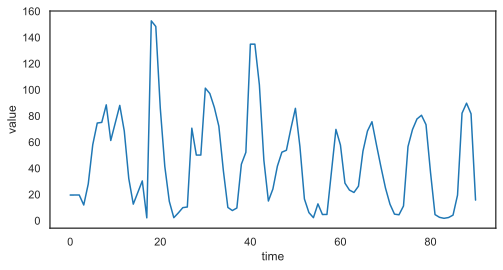

In [20]:
plt.figure(figsize=(8,4))
ax = sns.lineplot(data=X)
ax.set(xlabel='time', ylabel='value');

### Smooth the raw data
Let's smooth the data using our generator functions with 2 different time constants. We will simulate a streaming data environment by sending the x values to our lag filter in a for loop, one point at a time!

We then store the results in a list.

In [21]:
X_tau1 = []
X_tau2 = []
for indx, value in enumerate(X):
    X_tau1.append(lagfilter1.send(value))
    X_tau2.append(lagfilter2.send(value))

### The Results

We observe that:

- a higher time constant reduces the amplitude of our filtered outputs, which may be helpful for noise removal.
- but it also adds more lag to our filtered signal, the peaks are shifting towards the right

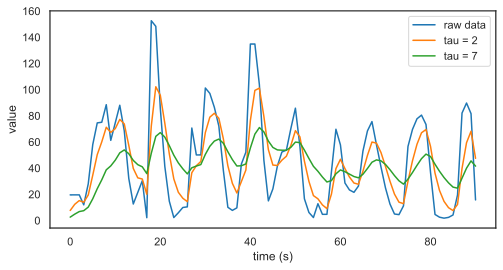

In [22]:
plt.figure(figsize=(8,4))
ax = sns.lineplot(data=X)
sns.lineplot(data=X_tau1)
sns.lineplot(data=X_tau2)
ax.set(xlabel='time (s)', ylabel='value');
plt.legend(['raw data', f"tau = {tau1}", f"tau = {tau2}"])

## Analyzing the effects of filtering

Lag filters can smooth noisy signals, which is important for certain applications like calculating derivatives, which amplifies noise. One important consideration is the effect of filtering on controller performance. In particular, filtering introduces **phase lag**.

From the textbook by Marlin (McMaster University, 2015) 2nd Edition
> There is a tendency to overfilter signals used for control. Thus, the following
recommendation should be considered: **Since the filter is a dynamic element in the feedback loop, signals used for control should be filtered no more than the minimum required to achieve good control performance.** - pg. 396

For simplicity, we will analyze the continuous form of the first order lag filter in the frequency domain by using a Bode plot.

$$
Y(s) = \frac{1}{1+\tau s}X(s)
$$

Set up our transfer function first using `control.tf`.

In [23]:
import control # use the python control library for convenience

tau1 = 1
G1  = control.tf([1],[tau1,1])
tau2 = 5
G2   = control.tf([1],[tau2,1])  # Transfer function for the filter
tau3 = 20
G3   = control.tf([1],[tau3,1])  # Transfer function for the filter

In [24]:
print(G1, G2, G3)


  1
-----
s + 1
 
   1
-------
5 s + 1
 
   1
--------
20 s + 1



### Bode diagram

A Bode diagram describes the magnitude and phase relationship between the input and output signals. We construct a Bode diagram by tracing how a hypothetical sine wave of different frequencies would change its magnitude and phase after passing through the filter block.

Would our hypothetical sine wave decay or grow? Would it show a phase change? The Bode diagram helps us answer these questions and tell us something about the stability of our system.

> We could in theory, generate a Bode diagram by step testing the process with a sine wave at various frequencies. In practice, we don't actually generate these sine waves or do our analysis one frequency at a time. This is where the Laplace transform comes in to help us perform this analysis conceptually.

#### Interpretation of the Bode plots:
- The **magnitude vs. frequency plot** shows how effective we are at removing noise. The higher frequencies contain the signal noise, and we want its output magnitude to be low.
- The **phase vs. frequency plot** shows how much phase lag we are introducing by applying the filter.

Why does this phase lag exist? Because our filter has a 'memory' of past values from $y(t-1)$ which is being blended into the output.

The ideal, perfect filter will have a Bode plot that looks like this (Marlin, pg. 390), allowing the true signal to pass through with zero phase lag. This filter does not exist in practice:

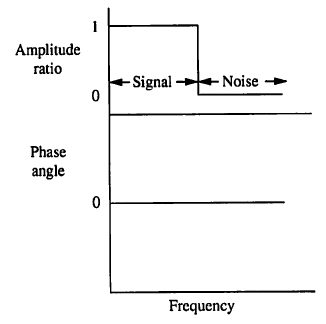

Let's look at how our Bode plot changes across different filter time constants.

Observe below that the higher the time constant $\tau$, the more reduction of high frequency noise we get, but we introduce more phase lag (negative shift).

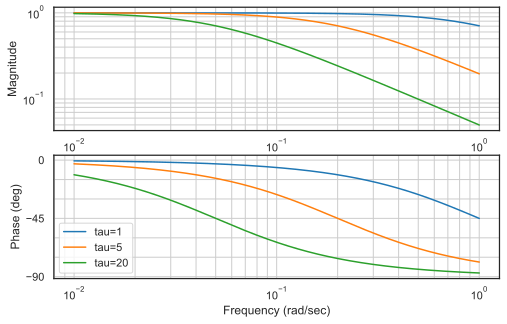

In [25]:
plt.figure(figsize=(8,5))
control.bode(G1, omega_limits=[1e-2,1]);
control.bode(G2, omega_limits=[1e-2,1]);
control.bode(G3, omega_limits=[1e-2,1]);
plt.legend([f"tau={tau}" for tau in [tau1, tau2, tau3]]);